In [724]:
# import stuff
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os

import cv2

import scipy
from scipy import signal
import h5py, time
from iminuit import Minuit, describe
from pprint import pprint # we use this to pretty print some stuff later
import glob
import pandas as pd
import sys
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import BeadDataFile
from discharge_tools import *
from AnaUtil import *
from bisect import bisect_left
from tqdm import tqdm

from joblib import Parallel, delayed
import multiprocessing
import datetime as dt
plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.labelsize'] = "small"
plt.rcParams['ytick.labelsize'] = 36

In [785]:
def load_img_files(path):
    # read in the data 
    files = glob.glob(path)
    files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))    
    img_files = []
    for i in range(0,len(files)):
        img_files.append(cv2.imread(files[i],0))
        print(files[i]) 
    return img_files

def laplacian(img):
    lap = np.sum(cv2.Laplacian(img,cv2.CV_64F)*cv2.Laplacian(img,cv2.CV_64F))
    return lap

def maxi(img):
    return np.argmax(np.mean(img,axis=1))

def gaussian(x,params=list):
        norm = (1/((1/2*params[2])*np.sqrt(np.pi * 2)))
        return params[0] * norm * np.exp(-(np.subtract(x,params[1])**2/(2*params[2]**2)))+np.multiply(params[3],x)+params[4]


In [789]:
images_before =load_img_files('/data/new_trap/ImageAnalysis/20200225/Image_Campaign_Attr_20200225/*')
images_after =load_img_files('/data/new_trap/ImageAnalysis/20200302/Image_Attractor_Campagin_20200302/*')


/data/new_trap/ImageAnalysis/20200225/Image_Campaign_Attr_20200225/1.bmp
/data/new_trap/ImageAnalysis/20200225/Image_Campaign_Attr_20200225/2.bmp
/data/new_trap/ImageAnalysis/20200225/Image_Campaign_Attr_20200225/3.bmp
/data/new_trap/ImageAnalysis/20200225/Image_Campaign_Attr_20200225/4.bmp
/data/new_trap/ImageAnalysis/20200225/Image_Campaign_Attr_20200225/5.bmp
/data/new_trap/ImageAnalysis/20200225/Image_Campaign_Attr_20200225/6.bmp
/data/new_trap/ImageAnalysis/20200225/Image_Campaign_Attr_20200225/7.bmp
/data/new_trap/ImageAnalysis/20200225/Image_Campaign_Attr_20200225/8.bmp
/data/new_trap/ImageAnalysis/20200225/Image_Campaign_Attr_20200225/9.bmp
/data/new_trap/ImageAnalysis/20200225/Image_Campaign_Attr_20200225/10.bmp
/data/new_trap/ImageAnalysis/20200225/Image_Campaign_Attr_20200225/11.bmp
/data/new_trap/ImageAnalysis/20200225/Image_Campaign_Attr_20200225/12.bmp
/data/new_trap/ImageAnalysis/20200225/Image_Campaign_Attr_20200225/13.bmp
/data/new_trap/ImageAnalysis/20200225/Image_Cam

In [786]:
#np.piecewise(x,[x>np.argmax(data_y),x<=np.argmax(data_y)],[constant1,constant2])

In [787]:
def gaussian_attr_pos_fit(img,axis=0,low_x_lim=100,up_x_lim=1100,low_y_lim=400,up_y_lim=500,upper_area=300,up_lim_width=15):

    def chisquare_1d(function, functionparams, data_x, data_y,data_y_error):
        chisquarevalue=np.sum(np.power(np.divide(np.subtract(function(data_x,functionparams),data_y),data_y_error),2))
        ndf = len(data_y)-len(functionparams)
        #print(ndf)
        return (chisquarevalue, ndf)


    
    def chisquare_gaussian(area,mean,sigma,constant1,constant2):
        return chisquare_1d(function=gaussian,functionparams=[area,mean,sigma,constant1,constant2],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]
   

    area=0
    mean=0
    sigma=0
    constant1=0
    constant2=0
    low_fitrange=50
    up_fitrange=10

    if(axis==0):
        img2 = img.transpose()
        data_y_input = np.mean(img2[low_x_lim:up_x_lim],axis=0) # give y data 
        data_x = np.arange(np.argmax(data_y_input)-low_fitrange,np.argmax(data_y_input)+up_fitrange,1)#range(1024) # give x data
        data_y = np.mean(img2[low_x_lim:up_x_lim],axis=0)[np.argmax(data_y_input)-low_fitrange:np.argmax(data_y_input)+up_fitrange] # give y data 
        data_y_error = np.sqrt(data_y) # give y uncertainty
        low_lim_mean = low_y_lim
        up_lim_mean = up_y_lim
        
    if(axis==1):
        data_x = range(1280) # give x data
        data_y = np.mean(img[low_y_lim:up_y_lim],axis=0) # give y data 
        data_y_error = np.sqrt(data_y) # give y uncertainty
        low_lim_mean = low_x_lim
        up_lim_mean = up_x_lim
        
        
    m=Minuit(chisquare_gaussian, 
             area = 100, # set start parameter
             error_area = 1,
             limit_area= (0,upper_area), # if you want to limit things
             #fix_area = "True", # you can also fix it
             mean = np.argmax(np.mean(img2[low_x_lim:up_x_lim],axis=0)),
             error_mean = 1,
             #fix_mean = "False",
             #limit_mean = (450,490),
             sigma = 4.5,
             error_sigma = 1,
             limit_sigma=(0,up_lim_width),
             constant1 = 0,
             fix_constant1=True,
             error_constant1 = 1,
             constant2 = 55,
             error_constant2 = 1,
             fix_constant2=False,
             errordef = 1,
             print_level=0)
    #print('Now proceed with the fit.')
    m.migrad(ncall=500000)
    #m.minos(), if you need fancy mapping
    chisquare=m.fval
    return m.values['mean'],m

In [802]:
mlist1 = []
for i in range(len(images_after)):
    m1 = gaussian_attr_pos_fit(img=images_after[i])
    mlist1.append(m1[0])
    

In [790]:
mlist2 = []
for i in range(len(images_before)):
    m2 = gaussian_attr_pos_fit(img=images_before[i])
    mlist2.append(m2[0])
    

3.771257008411857 8.880631598371693


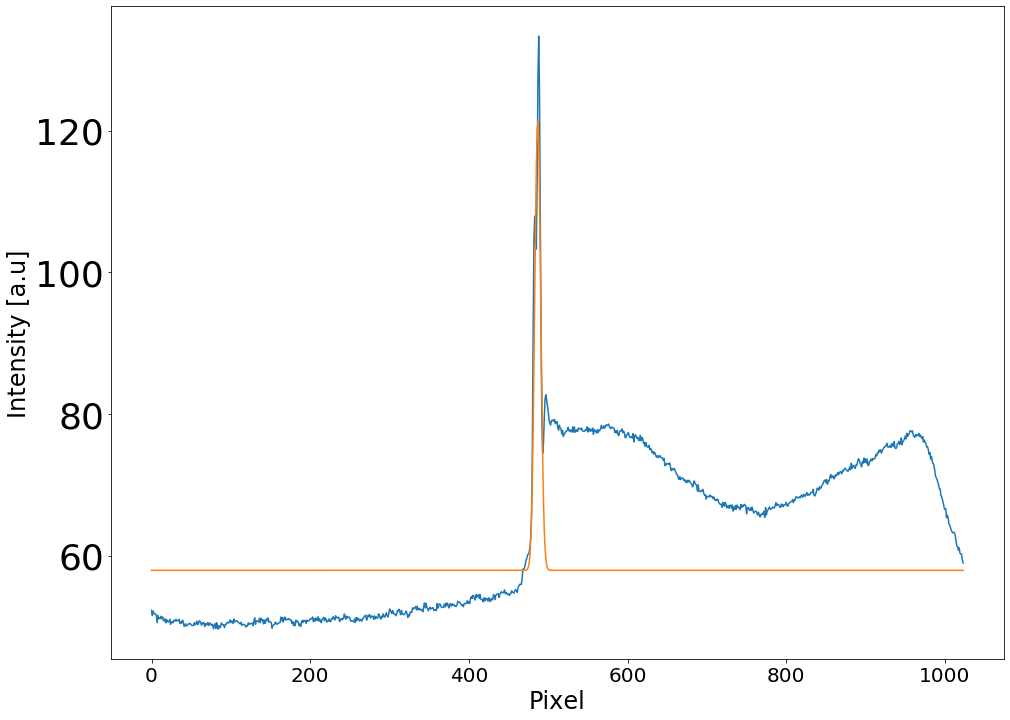

In [795]:
index = 15
m1 = gaussian_attr_pos_fit(img=images_after[index])
print(m1[1].values["sigma"],2*np.sqrt(2*np.log(2))*m1[1].values["sigma"])
plt.plot(np.mean(images_after[index],axis=1))
#plt.plot(np.mean(images_before[index],axis=1))

plt.plot(gaussian(range(1024),params=[m1[1].values["area"],m1[1].values["mean"],m1[1].values["sigma"],m1[1].values["constant1"],m1[1].values["constant2"]]))
plt.xlabel("Pixel")
plt.ylabel("Intensity [a.u]")
#plt.savefig("full_attractor_marginialization_y_20200226.png",dpi=300,bbox_inches="tight")
plt.show()
#plt.xlim(400,600)
#plt.ylim(0,150)

3.655334942064574 8.607655992875703


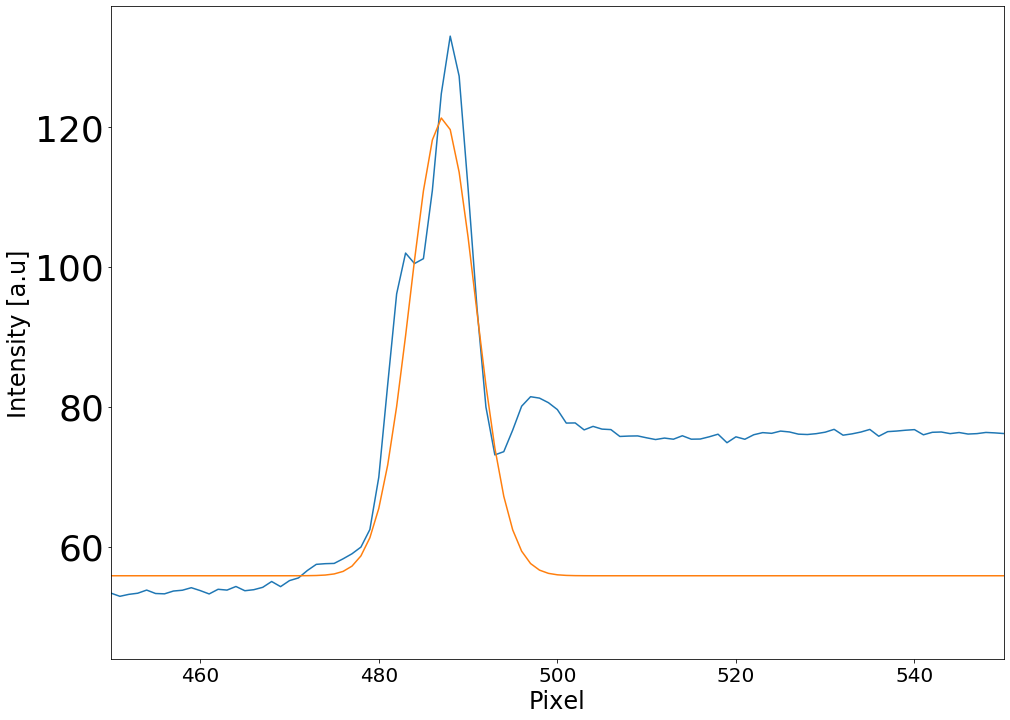

In [796]:
index = 11
m1 = gaussian_attr_pos_fit(img=images_after[index])
print(m1[1].values["sigma"],2*np.sqrt(2*np.log(2))*m1[1].values["sigma"])
plt.plot(np.mean(images_after[index],axis=1))
plt.plot(gaussian(range(1024),params=[m1[1].values["area"],m1[1].values["mean"],m1[1].values["sigma"],m1[1].values["constant1"],m1[1].values["constant2"]]))
plt.xlabel("Pixel")
plt.ylabel("Intensity [a.u]")
plt.xlim(450,550)
#plt.savefig("full_attractor_marginialization_y_zoomed_20200226.png",dpi=300,bbox_inches="tight")
plt.show()
#plt.xlim(400,600)
#plt.ylim(0,150)

In [798]:
# for images after
z2= np.arange(43.0,45.5,0.5)
z3 = np.arange(45.2,46.2,0.2)
z4 = np.arange(46.5,51.5,0.5)
z5=np.arange(52,61,1)
z6 = [50]*3
z=list(z2)+list(z3)+list(z4)+list(z5)+list(z6)

# for images before
zb1= np.arange(46.0,51.5,0.5)
zb2=np.linspace(46,43,7)
zb=list(zb1)+list(zb2)


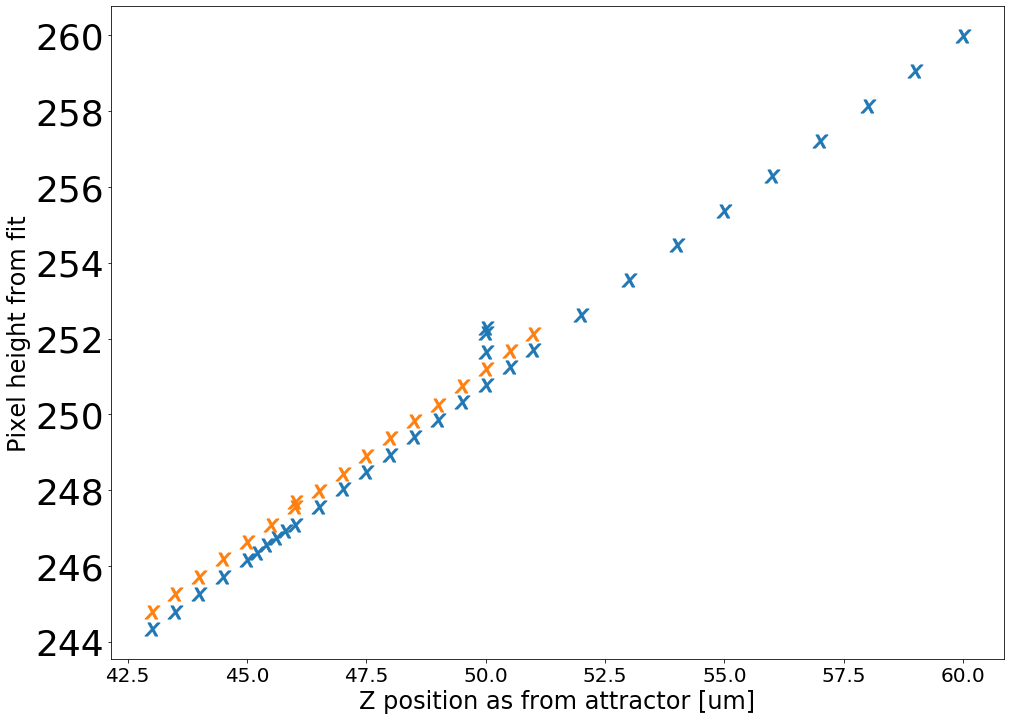

In [818]:
plt.plot(z,1024*0.46-np.multiply(0.46,mlist1[20:]), linestyle="",marker="$x$",markersize=15)
plt.plot(zb,1024*0.46-np.multiply(0.46,mlist2[19:37]), linestyle="",marker="$x$",markersize=15)
#plt.xlim(49.5,50.5)
#plt.ylim(244,248)
plt.xlabel("Z position as from attractor [um]")
plt.ylabel("Pixel height from fit")
plt.savefig("Results/Height_Measurement_two_campaign.png",dpi=300,bbox_inches="tight")
#plt.ylim(243,245)
plt.show()
#plt.xlim(0,19)


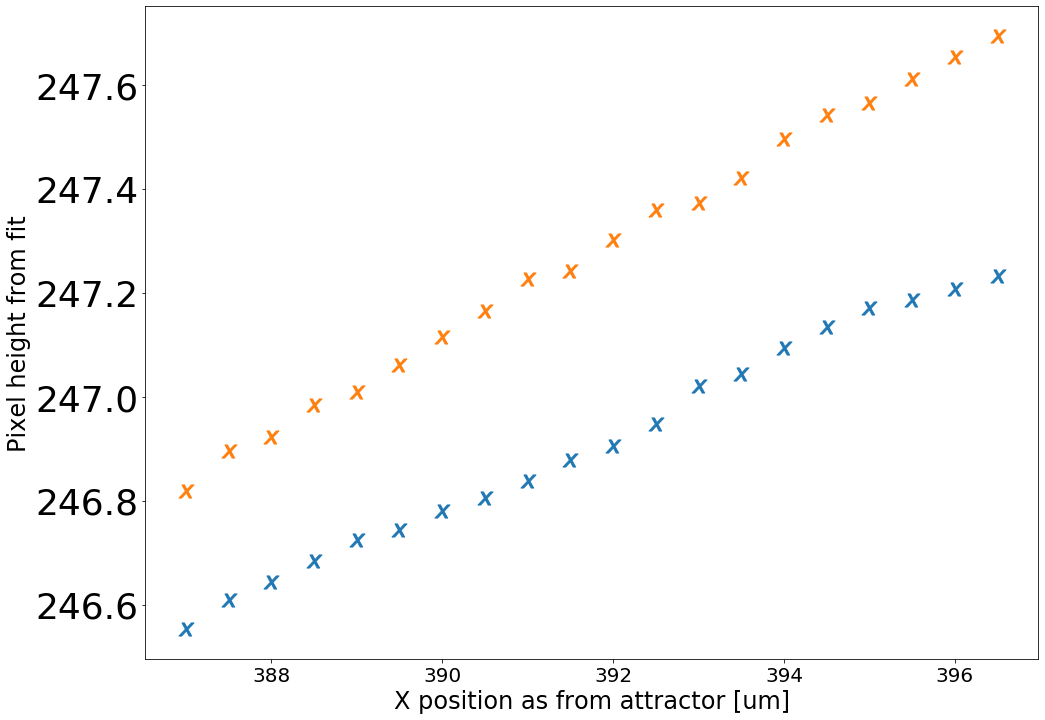

In [817]:
z1= np.arange(387,397,0.5)
plt.plot(z1,1024*0.46-np.multiply(0.46,mlist1[0:20]), linestyle="",marker="$x$",markersize=15)
plt.plot(z1,1024*0.46-np.multiply(0.46,mlist2[0:20]), linestyle="",marker="$x$",markersize=15)

#plt.grid()
#plt.xlim(19.5,37)
plt.xlabel("X position as from attractor [um]")
plt.ylabel("Pixel height from fit")
#plt.savefig("Results/Height_Measurement_as_function_of_distance_20200226.png",dpi=300,bbox_inches="tight")
plt.show()
#plt.xlim(0,19)
#plt.ylim(486,488)